In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w

from sqlalchemy import text, create_engine

# Exercises
Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')

    return pd.Series(output)

In [3]:
# cao ~May 2023, new pandas update made it so we have to do sql pulls differently:
# getting url is the same
url = w.get_db_url('logs')
# create this "engine" and use it to make a "connection"
engine = create_engine(url)
connection = engine.connect()
# use the text function to turn a string query into the format needed
query = text('SELECT * FROM api_access')
# Now we can use the connection and read the query into a dataframe
df = pd.read_sql(query, connection)

#### HERE are 3 lines of code that do all of the above:
# url = w.get_db_url('logs')
# engine = create_engine(url)
# df = pd.read_sql(text('SELECT * FROM api_access'), engine.connect())

In [4]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [5]:
# apply the parse_log_entry function to all the entry's in the df
# this will break up the one string in each entry into several columns; more useful
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


## For the sake of this lesson, we willc reate some synthetic records and append them to our existing data frame.

In [6]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])


In [7]:
# make a size_mb column from the 'size' column which is in bytes
df['size_mb'] = df['size'] / 1024 / 1024

In [11]:
# make the date column into the index and sort it
df.timestamp = df.timestamp.astype('datetime64')

In [12]:
df = df.set_index('timestamp')
df = df.sort_index()

In [13]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [14]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
97.105.15.120         1
95.31.16.121          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
95.31.18.119          1
Name: ip, dtype: int64

In [15]:
df.ip.value_counts(normalize=True)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
35.175.171.137    0.000143
52.87.230.102     0.000143
70.121.214.34     0.000143
52.90.165.200     0.000072
97.105.15.120     0.000072
95.31.16.121      0.000072
45.23.250.16      0.000072
52.91.30.150      0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
54.172.14.223     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
54.145.52.184     0.000072
34.229.70.250     0.000072
95.31.18.119      0.000072
Name: ip, dtype: float64

In [27]:
# function from Codeup with a couple things I don't understand in the def'n
def value_counts_and_frequencies_codeup(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [28]:
# my function. very similar
def value_counts_and_frequencies (s):
    """
    This function will
    - accept a series, s
    - conduct value_counts() with both normalize=False and True
    - put the results together into a dataframe where the index is the value, count is the count
      , and proba is the probability of the index value occurring in the 
      series, s (i.e. count / length of the series)
    - return that dataframe of value counts and percentages
    """
    df = pd.merge(s.value_counts().rename('count')
                 , s.value_counts(normalize=True).rename('proba')
                 , left_index=True, right_index=True)
    return df

In [31]:
# get dataframe of df.ip value_counts
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<AxesSubplot:>

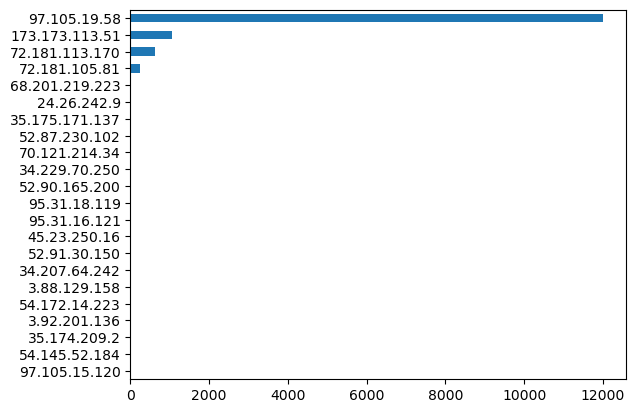

In [37]:
# plot ip_df (# the vast majority of the results come from 97.105.19.58
ip_df['count'].sort_values().plot.barh()

## Conditional Probabilities: Probabilities using 2 discrete variables
Bayes:
P (A|B) = P(A & B) / P(B)

In [41]:
df.groupby('ip').status_code.value_counts()

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
95.31.16.121    301                1
95.31.18.119    200                1
97.105.15.120   301                1
97.105.19.58    200            11985
                499               14
Name: status_code, dtype: int64

In [48]:
# code from Codeup- makes a new dataframe with the groupby...rename
# then resets the index so it's no longer a multilevel index
# So P (A|B) is P(status_code | ip address)
status_code_given_ip = df.groupby('ip').status_code.value_counts(normalize=True).rename('prob_status_given_ip').reset_index()
status_code_given_ip

,ip,status_code,prob_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [50]:
# to look for anomalies, we could do a couple of things
# - cases where the probability is < 100%
status_code_given_ip[status_code_given_ip.prob_status_given_ip < 1]

,ip,status_code,prob_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [52]:
# or we could simply look for status_codes that are NOT 200
status_code_given_ip[status_code_given_ip.status_code != '200']

,ip,status_code,prob_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [53]:
# NOW, do the rest of the exercise, namely:
# Use basic probability to identify anomalous requests.
# Using the methods covered in this lesson (above), 
# examine the rest of the features in the api access logs data set

In [54]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [61]:
# all requests were 'GET'
df.request_method.value_counts()

GET    13978
Name: request_method, dtype: int64

In [62]:
# all http versions are the same
df.http_version.value_counts()

HTTP/1.1    13978
Name: http_version, dtype: int64

<AxesSubplot:>

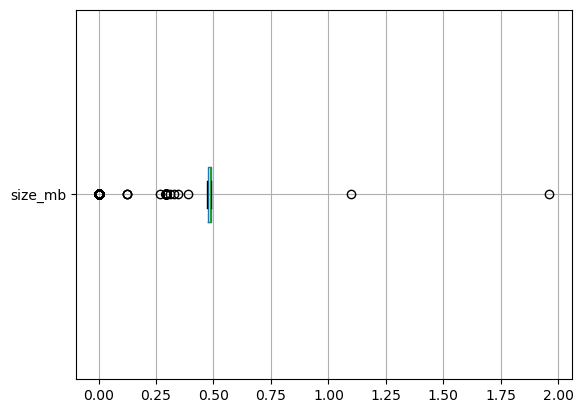

In [79]:
# size_mb is continuous, and even though there are a couple outliers,
# I wouldn't consider them anomalies necessarily. They could be, though
df[['size_mb']].boxplot(vert=False)

In [75]:
# only two entries had download sizes > 1 Mb - outlier or anomaly? 
df[df.size_mb > .75]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591


In [76]:
# > 1500 rows had less than .01 Mb.  So that sounds fairly normal
df[df.size_mb < .01]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266
2019-04-16 19:34:52,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040
2019-04-16 19:34:53,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:53,97.105.19.58,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0,0.003489
...,...,...,...,...,...,...,...,...
2019-04-17 06:16:10,24.26.242.9,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-17 06:16:10,24.26.242.9,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266
2019-04-17 10:25:50,45.23.250.16,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266


In [71]:
# maybe request_path and status_code have some anomalies?
status_code_given_request_path = df.groupby('request_path').status_code.value_counts(normalize=True).rename('prob_code_given_request_path').reset_index()
status_code_given_request_path

,request_path,status_code,prob_code_given_request_path
0,/,200,1.0
1,/api/V1/HiZach!,200,1.0
2,/api/v1,200,1.0
3,/api/v1/,200,1.0
4,/api/v1//api/v1/items,200,1.0
...,...,...,...
227,/api/v1/stores?page=666,200,1.0
228,/api/v1/stores?page=999,200,1.0
229,/api/v1items,200,1.0
230,/documentation,200,1.0


In [72]:
# look for status codes that aren't 200
status_code_given_request_path[status_code_given_request_path.status_code != '200']

,request_path,status_code,prob_code_given_request_path
10,/api/v1/items,499,0.008621
44,/api/v1/sales?page=115,499,0.016393
65,/api/v1/sales?page=133,499,0.016667
123,/api/v1/sales?page=2,499,0.004231
126,/api/v1/sales?page=21,499,0.013699
131,/api/v1/sales?page=25,499,0.014085
136,/api/v1/sales?page=29,499,0.014493
157,/api/v1/sales?page=47,499,0.014925
182,/api/v1/sales?page=69,499,0.015625
194,/api/v1/sales?page=79/,301,0.666667


In [74]:
# one request_path looks like a high percentage of non-200 status_codes
df[df.request_path == '/api/v1/sales?page=79/']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066


In [78]:
# what about user_agent and status_code
user_agent_given_status_code = df.groupby('user_agent').status_code.value_counts(normalize=True).rename('prob_user_agent_given_status_code').reset_index()
user_agent_given_status_code

,user_agent,status_code,prob_user_agent_given_status_code
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,200,1.000000
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.000000
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.000000
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,200,1.000000
4,Python-urllib/3.7,200,1.000000
5,Slackbot 1.0 (+https://api.slack.com/robots),200,1.000000
6,Slackbot-LinkExpanding 1.0 (+https://api.slack...,200,1.000000
7,python-requests/2.20.1,200,0.997907
8,python-requests/2.20.1,499,0.002093
9,python-requests/2.21.0,200,0.998834
